In [ ]:
# ==========================================
# 1. Instalación de librerías
# ==========================================
!pip install lightgbm
!pip install pandas

# ==========================================
# 2. Importación de librerías y configuración
# ==========================================
import os
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from google.colab import drive

# ==========================================
# 3. Montar Google Drive
# ==========================================
drive.mount('/content/drive')

# ==========================================
# 4. Configuración de parámetros del modelo y dataset
# ==========================================
PARAM = {
    'experimento': 'KA_250087_copy',
    'semilla_primigenia': 250087,
    'input': {
        'dataset': '/content/drive/MyDrive/Maestria/DMEYF/datasets/competencia_01_fe.csv',  # ruta en Colab
        'training': [202104],
        'future': [202106]
    },
    'finalmodel': {
        'num_iterations': 613,
        'learning_rate': 0.01,
        'feature_fraction': 0.5489793063,
        'min_data_in_leaf': 1014,
        'num_leaves': 928,
        'max_bin': 31
    }
}

# ==========================================
# 5. Cargar el dataset y preprocesar
# ==========================================
# Cargar el dataset
dataset = pd.read_csv(PARAM['input']['dataset'])

# Crear la columna 'clase01' que será la clase binaria
dataset['clase01'] = np.where(dataset['clase_ternaria'].isin(['BAJA+1', 'BAJA+2']), 1, 0)

# Seleccionar los campos relevantes, excluyendo columnas problemáticas
campos_buenos = [col for col in dataset.columns if col not in ['clase_ternaria', 'cprestamos_personales', 'mprestamos_personales']]

# Marcar las filas que serán para el entrenamiento (según 'foto_mes')
dataset['train'] = np.where(dataset['foto_mes'].isin(PARAM['input']['training']), 1, 0)

# ==========================================
# 6. Ingeniería de Features (Lags + Delta_lags)
# ==========================================
# Variables para las que se crearán lags
variables_lags = ['mrentabilidad', 'mcomisiones', 'cliente_edad']

# Creación de lags
for variable in variables_lags:
    for lag in [1, 2, 3]:  # Ajustable según sea necesario
        dataset[f'{variable}_lag{lag}'] = dataset.groupby('numero_de_cliente')[variable].shift(lag)

# Creación de deltas entre lags
for variable in variables_lags:
    for lag in [1, 2]:
        dataset[f'{variable}_delta_lag{lag}'] = dataset[f'{variable}_lag{lag}'] - dataset[f'{variable}_lag{lag+1}']

# Imputación de valores faltantes generados por los lags
dataset.fillna(0, inplace=True)

# ==========================================
# 7. Exploratory Data Analysis (EDA)
# ==========================================
# Resumen estadístico del conjunto de entrenamiento (202104)
print("Resumen estadístico del conjunto de entrenamiento (202104):")
print(dataset[dataset['foto_mes'] == 202104][campos_buenos].describe())

# ==========================================
# 8. Preparación de los datos para el modelo
# ==========================================
# Selección de campos para el modelo
campos_buenos = [col for col in dataset.columns if col not in ['clase_ternaria', 'clase01', 'cprestamos_personales', 'mprestamos_personales']]

# Preparación del Dataset de LightGBM
dtrain = lgb.Dataset(
    dataset[dataset['train'] == 1][campos_buenos],  # Variables independientes
    label=dataset[dataset['train'] == 1]['clase01']  # Variable dependiente
)

# Definir Parámetros del Modelo
lgb_params = {
    'objective': 'binary',  # Clasificación binaria
    'max_bin': PARAM['finalmodel']['max_bin'],
    'learning_rate': PARAM['finalmodel']['learning_rate'],
    'num_iterations': PARAM['finalmodel']['num_iterations'],
    'num_leaves': PARAM['finalmodel']['num_leaves'],
    'min_data_in_leaf': PARAM['finalmodel']['min_data_in_leaf'],
    'feature_fraction': PARAM['finalmodel']['feature_fraction'],
    'seed': PARAM['semilla_primigenia']  # Para reproducibilidad
}

# ==========================================
# 9. Entrenamiento del modelo
# ==========================================
modelo = lgb.train(
    params=lgb_params,
    train_set=dtrain
)

# ==========================================
# 10. Importancia de las variables
# ==========================================
importancia = modelo.feature_importance()
tb_importancia = pd.DataFrame({
    'Feature': dataset[campos_buenos].columns,
    'Importance': importancia
})

# Guardar la importancia de las variables
tb_importancia.to_csv('impo.txt', sep='\t', index=False)

# ==========================================
# 11. Predicciones para el mes futuro
# ==========================================
# Filtrar los datos del mes futuro (202106)
dapply = dataset[dataset['foto_mes'].isin(PARAM['input']['future'])]

# Realizar las predicciones
prediccion = modelo.predict(dapply[campos_buenos])

# Crear tabla de entrega con número de cliente y probabilidad
tb_entrega = dapply[['numero_de_cliente', 'foto_mes']].copy()
tb_entrega['prob'] = prediccion

# Guardar las probabilidades predichas
tb_entrega.to_csv('prediccion.txt', sep='\t', index=False)

# ==========================================
# 12. Generación de archivos para Kaggle
# ==========================================
# verificar que existe la carpeta
output_dir = '/content/drive/MyDrive/Maestria/DMEYF/Kaggle'
os.makedirs(output_dir, exist_ok=True)  # Crea la carpeta si no existe

# Ordenar por probabilidad descendente
tb_entrega = tb_entrega.sort_values(by='prob', ascending=False)

# Generar archivos para Kaggle en cortes de 9000 a 13000
cortes = range(9000, 13001, 500)
for envios in cortes:
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1

    # Guardar el archivo en formato CSV en Google Drive
    archivo = os.path.join(output_dir, f"{PARAM['experimento']}_{envios}.csv")
    tb_entrega[['numero_de_cliente', 'Predicted']].to_csv(archivo, index=False)

print("\n\nArchivos para Kaggle ha terminado.")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/drive
Resumen estadístico del conjunto de entrenamiento (202104):
       numero_de_cliente  foto_mes  active_quarter    cliente_vip  \
count       1.640900e+05  164090.0   164090.000000  164090.000000   
mean        7.722717e+08  202104.0        0.987464       0.002718   
std         3.231573e+08       0.0        0.111260       0.052064   
min         2.492211e+08  202104.0        0.000000       0.000000   
25%         5.198533e+08  202104.0        1.000000       0.000000   
50%         7.338291e+08  202104.0        1.000000       0.000000   
75%         9.994675e+08  202104.0        1.000000       0.000000   
max         1.592803e+09  202104.0        1.000000       1.000000   

            internet   cliente_edad  cliente_antiguedad  mrentabilidad  \
count  164090.000000  164090.000000       164090.000000   1.640900e+05   
mean        0.062557      46.914900          133.745365   1.974653e+03   
std         0.314061      12.946613           85.742614   1.167212e+04

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2171, number of negative: 161919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3571
[LightGBM] [Info] Number of data points in the train set: 164090, number of used features: 144
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013231 -> initscore=-4.311908
[LightGBM] [Info] Start training from score -4.311908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

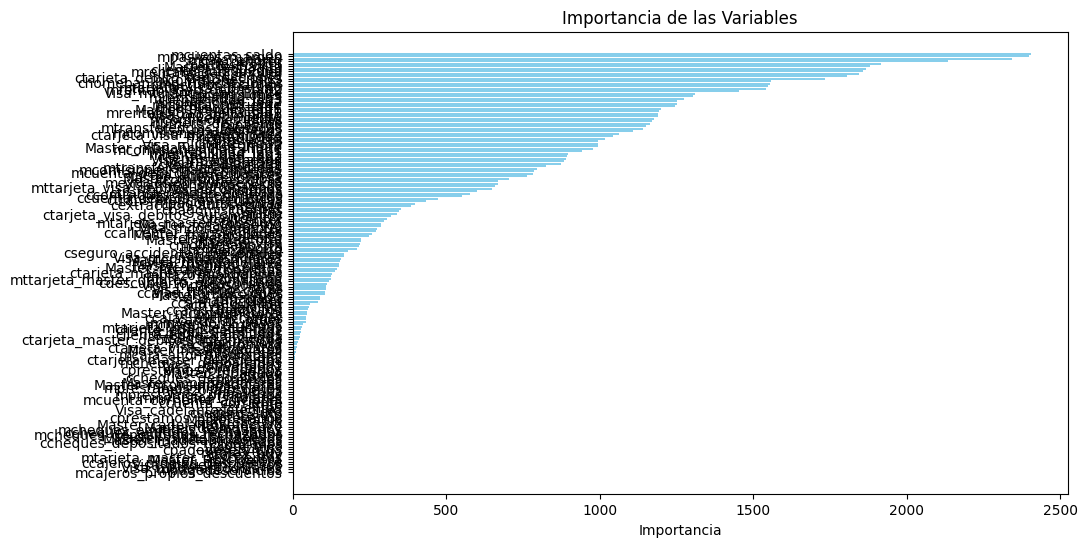

In [ ]:
import matplotlib.pyplot as plt

# Ordenar las variables por importancia
tb_importancia = tb_importancia.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(tb_importancia['Feature'], tb_importancia['Importance'], color='skyblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Variables")
plt.gca().invert_yaxis()  # Para que las más importantes aparezcan arriba
plt.show()
